# DAIDEC challange

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


%matplotlib inline 
pd.options.display.max_columns = None



In [2]:
dataset_0 = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')
#dataset_0 = pd.read_csv('clean_dataset.csv')

/home/adminux/anaconda3/envs/tf2.2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (34,36,38,44,46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Executive Summary
The report here presents exploratory data analysis of the HMDA mortgage application dataset along with the machine learning predicting model for loan approval. The dataset can be downloaded from CFPB website at:
https://www.consumerfinance.gov/data-research/hmda/historic-data/

After doing basic exploratory analysis, visualization and data cleaning and processing, the most essential features of the dataset are identified that provide information two label classes (mortgage accepted/rejected).

Those features were subsequentely used for the creation of a binary classifier capable of predicting whether an application will be accepted or not, with an accuracy of 73%. The most important features of the dataset are the following, however the description of all label can be found at:
https://files.consumerfinance.gov/hmda-historic-data-dictionaries/lar_record_codes.pdf


* *loan_amount* - Size of the requested loan in thousands of dollars
* *msamd* - A categorical with no ordering indicating Metropolitan Statistical Area/Metropolitan Division 
* *state_code* - A categorical with no ordering indicating the U.S. state
* *country_code* - Three-digit FIPS county identifier
* *applicant_income* - In thousands of dollars
* *number_of_owner-occupied_units* - Number of dwellings, including individual condominiums, that are lived in by the owner
* *minority_population* - Number of people that belong in a minority group, a new feature that was created for the purposes of this analysis
* *tract_family_income* - The tract median family income in dollars, another feature that was created for the purposes of this analysis

# Exploratory Data Analysis
First of all, the total number of rows and number of non-null values for each feature need to be examined.

In [3]:
dataset_0.count()

as_of_year                        14285496
respondent_id                     14285496
agency_name                       14285496
agency_abbr                       14285496
agency_code                       14285496
                                    ...   
hud_median_family_income          14001188
tract_to_msamd_income             14001188
number_of_owner_occupied_units    14001144
number_of_1_to_4_family_units     14001144
application_date_indicator               0
Length: 78, dtype: int64

In [4]:
#checking for null values
dataset_0.isnull().sum()

as_of_year                               0
respondent_id                            0
agency_name                              0
agency_abbr                              0
agency_code                              0
                                    ...   
hud_median_family_income            284308
tract_to_msamd_income               284308
number_of_owner_occupied_units      284352
number_of_1_to_4_family_units       284352
application_date_indicator        14285496
Length: 78, dtype: int64

After initial EDA, it found out that the following columns need to be dropped due to incompleteness, correlation with other columns and the lack of data.

In [5]:
dataset_0.drop(['as_of_year', 'agency_name', 'respondent_id', 'agency_abbr', 'loan_type_name', 
                'property_type_name', 'loan_purpose_name', 'owner_occupancy_name', 'preapproval_name', 
                'action_taken_name', 
                'msamd_name', 'state_name', 'state_abbr', 'county_name', 'applicant_ethnicity_name',
                'co_applicant_ethnicity_name', 'applicant_race_name_1', 'applicant_race_name_2', 
                'applicant_race_name_3', 'applicant_race_name_4', 'applicant_race_name_5',
                'co_applicant_race_name_1', 'co_applicant_race_name_2', 'co_applicant_race_name_3', 
                'co_applicant_race_name_4', 'co_applicant_race_name_5', 'applicant_sex_name', 
                'co_applicant_sex_name', 'purchaser_type_name', 'denial_reason_name_1', 'denial_reason_name_2', 
                'denial_reason_name_3', 'hoepa_status_name', 'lien_status_name', 'edit_status_name', 
                'applicant_race_2', 'applicant_race_3', 'applicant_race_4', 
                'applicant_race_5', 'co_applicant_race_2', 'co_applicant_race_3', 'co_applicant_race_4', 
                'co_applicant_race_5', 'denial_reason_1', 'denial_reason_2', 'denial_reason_3', 'rate_spread', 
                'edit_status', 'sequence_number', 'application_date_indicator'], axis=1, inplace=True)

In [6]:
dataset_0.head(10)

,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,msamd,state_code,county_code,census_tract_number,applicant_ethnicity,co_applicant_ethnicity,applicant_race_1,co_applicant_race_1,applicant_sex,co_applicant_sex,applicant_income_000s,purchaser_type,hoepa_status,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units
0,7,1,1,3,1,53.0,3,4,37964.0,42.0,101.0,173.00,2,5,3,8,1,5,12.0,0,2,1,3202.0,97.279999,57400.0,47.540001,710.0,1314.0
1,9,1,1,3,1,168.0,3,3,44060.0,53.0,63.0,127.01,2,2,5,5,1,2,60.0,0,2,1,3733.0,4.580000,63900.0,86.239998,861.0,1241.0
2,7,1,1,3,1,103.0,3,5,41620.0,49.0,35.0,1136.00,3,3,6,6,1,2,50.0,0,2,1,5498.0,37.919998,75400.0,63.939999,1270.0,1658.0
3,7,1,1,3,2,88.0,3,1,44180.0,29.0,77.0,11.00,2,5,5,8,2,5,53.0,3,2,1,3566.0,11.830000,55200.0,74.290001,573.0,1261.0
4,7,1,1,3,1,90.0,3,4,16974.0,17.0,31.0,306.04,2,5,5,8,1,5,29.0,0,2,1,2910.0,48.660000,77500.0,79.250000,599.0,26.0
5,7,2,2,1,1,202.0,3,4,47664.0,26.0,99.0,2180.00,2,5,5,8,1,5,43.0,0,2,1,7618.0,26.570000,79600.0,72.160004,1565.0,2179.0
6,9,1,1,2,2,5.0,3,3,36740.0,12.0,97.0,429.00,1,5,6,8,1,5,NaN,0,2,3,17107.0,70.050003,58400.0,73.940002,2546.0,4722.0
7,9,1,1,1,2,185.0,3,3,40140.0,6.0,65.0,432.27,2,5,2,8,2,5,51.0,0,2,1,7404.0,57.520000,63200.0,116.010002,1215.0,1743.0
8,9,1,1,1,1,1079.0,3,1,36084.0,6.0,1.0,4038.00,3,3,6,6,3,3,278.0,0,2,1,3372.0,33.189999,97400.0,141.740005,592.0,1105.0
9,2,1,1,3,2,94.0,3,1,29404.0,55.0,59.0,22.00,2,5,5,8,2,5,31.0,0,2,1,3779.0,15.370000,91600.0,71.129997,1019.0,1465.0


In [7]:
dataset_0.count()

agency_code                       14285496
loan_type                         14285496
property_type                     14285496
loan_purpose                      14285496
owner_occupancy                   14285496
loan_amount_000s                  14280460
preapproval                       14285496
action_taken                      14285496
msamd                             12494446
state_code                        14088338
county_code                       14039899
census_tract_number               14001194
applicant_ethnicity               14285496
co_applicant_ethnicity            14285496
applicant_race_1                  14285496
co_applicant_race_1               14285496
applicant_sex                     14285496
co_applicant_sex                  14285496
applicant_income_000s             12389632
purchaser_type                    14285496
hoepa_status                      14285496
lien_status                       14285496
population                        14001188
minority_po

In [8]:
dataset_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14285496 entries, 0 to 14285495
Data columns (total 28 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   agency_code                     int64  
 1   loan_type                       int64  
 2   property_type                   int64  
 3   loan_purpose                    int64  
 4   owner_occupancy                 int64  
 5   loan_amount_000s                float64
 6   preapproval                     int64  
 7   action_taken                    int64  
 8   msamd                           float64
 9   state_code                      float64
 10  county_code                     float64
 11  census_tract_number             float64
 12  applicant_ethnicity             int64  
 13  co_applicant_ethnicity          int64  
 14  applicant_race_1                int64  
 15  co_applicant_race_1             int64  
 16  applicant_sex                   int64  
 17  co_applicant_sex         

In [9]:
#checking for null values
dataset_0.isnull().sum()

agency_code                             0
loan_type                               0
property_type                           0
loan_purpose                            0
owner_occupancy                         0
loan_amount_000s                     5036
preapproval                             0
action_taken                            0
msamd                             1791050
state_code                         197158
county_code                        245597
census_tract_number                284302
applicant_ethnicity                     0
co_applicant_ethnicity                  0
applicant_race_1                        0
co_applicant_race_1                     0
applicant_sex                           0
co_applicant_sex                        0
applicant_income_000s             1895864
purchaser_type                          0
hoepa_status                            0
lien_status                             0
population                         284308
minority_population               

As one can see, some of the features have a fair number of missing values. Furthermore, we can read on the dataset description that some categorical features include categories that correspond to missing values, e.g. the -1 category of *msamd* column indicates a missing value. We are going to remove those, so we have a clearer view of our dataset.

In [10]:
replace_dict = {
    'msamd': -1,
    'state_code': -1,
    'county_code': -1,
    'owner_occupancy': 3,
    'preapproval': 3,
    'applicant_ethnicity': [3, 4, 5],
    'co_applicant_ethnicity': [3, 4, 5],
    'applicant_race_1': [6, 7, 8],
    'co_applicant_race_1': [6, 7, 8],
    'applicant_sex': [3, 4, 5],
    'co_applicant_sex': [3, 4, 5],
    'loan_purpose': [2, 3]  # only loans for 'home purchase' 
}


dataset_0.replace(replace_dict, np.nan, inplace = True)
dataset_0.count()

agency_code                       14285496
loan_type                         14285496
property_type                     14285496
loan_purpose                       7703630
owner_occupancy                   14222608
loan_amount_000s                  14280460
preapproval                        2425789
action_taken                      14285496
msamd                             12494446
state_code                        14088338
county_code                       14039899
census_tract_number               14001194
applicant_ethnicity               11221264
co_applicant_ethnicity             4817461
applicant_race_1                  11130656
co_applicant_race_1                4789763
applicant_sex                     11808517
co_applicant_sex                   5092301
applicant_income_000s             12389632
purchaser_type                    14285496
hoepa_status                      14285496
lien_status                       14285496
population                        14001188
minority_po

In [11]:
dataset_0.head(10)

,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,msamd,state_code,county_code,census_tract_number,applicant_ethnicity,co_applicant_ethnicity,applicant_race_1,co_applicant_race_1,applicant_sex,co_applicant_sex,applicant_income_000s,purchaser_type,hoepa_status,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units
0,7,1,1,NaN,1.0,53.0,NaN,4,37964.0,42.0,101.0,173.00,2.0,NaN,3.0,NaN,1.0,NaN,12.0,0,2,1,3202.0,97.279999,57400.0,47.540001,710.0,1314.0
1,9,1,1,NaN,1.0,168.0,NaN,3,44060.0,53.0,63.0,127.01,2.0,2.0,5.0,5.0,1.0,2.0,60.0,0,2,1,3733.0,4.580000,63900.0,86.239998,861.0,1241.0
2,7,1,1,NaN,1.0,103.0,NaN,5,41620.0,49.0,35.0,1136.00,NaN,NaN,NaN,NaN,1.0,2.0,50.0,0,2,1,5498.0,37.919998,75400.0,63.939999,1270.0,1658.0
3,7,1,1,NaN,2.0,88.0,NaN,1,44180.0,29.0,77.0,11.00,2.0,NaN,5.0,NaN,2.0,NaN,53.0,3,2,1,3566.0,11.830000,55200.0,74.290001,573.0,1261.0
4,7,1,1,NaN,1.0,90.0,NaN,4,16974.0,17.0,31.0,306.04,2.0,NaN,5.0,NaN,1.0,NaN,29.0,0,2,1,2910.0,48.660000,77500.0,79.250000,599.0,26.0
5,7,2,2,1.0,1.0,202.0,NaN,4,47664.0,26.0,99.0,2180.00,2.0,NaN,5.0,NaN,1.0,NaN,43.0,0,2,1,7618.0,26.570000,79600.0,72.160004,1565.0,2179.0
6,9,1,1,NaN,2.0,5.0,NaN,3,36740.0,12.0,97.0,429.00,1.0,NaN,NaN,NaN,1.0,NaN,NaN,0,2,3,17107.0,70.050003,58400.0,73.940002,2546.0,4722.0
7,9,1,1,1.0,2.0,185.0,NaN,3,40140.0,6.0,65.0,432.27,2.0,NaN,2.0,NaN,2.0,NaN,51.0,0,2,1,7404.0,57.520000,63200.0,116.010002,1215.0,1743.0
8,9,1,1,1.0,1.0,1079.0,NaN,1,36084.0,6.0,1.0,4038.00,NaN,NaN,NaN,NaN,NaN,NaN,278.0,0,2,1,3372.0,33.189999,97400.0,141.740005,592.0,1105.0
9,2,1,1,NaN,2.0,94.0,NaN,1,29404.0,55.0,59.0,22.00,2.0,NaN,5.0,NaN,2.0,NaN,31.0,0,2,1,3779.0,15.370000,91600.0,71.129997,1019.0,1465.0


Further investigation in features reaveals that some other columns need to be dropped:
* *preapproval*: lack of data
* *co_applicant_ethnicity*: lack of data
* *co_applicant_race_1*: lack of data
* *loan_purpose*: only 'Home purchase' loan will be considered, so there is no need for column with constatnt data
* *hoepa_status*: constant number = 2
* *purchaser_type*: data will be filled after loan approval thus it intrupt the prediction.



In [12]:
dataset_0.drop(['preapproval', 'co_applicant_ethnicity', 'co_applicant_race_1', 
                'co_applicant_sex'], axis=1, inplace=True) # low number of usful data after removing 'not applicable' values
dataset_0.drop(['loan_purpose'], axis=1, inplace=True) # only 'Home purchase' loan will be considered


dataset_0.drop(['hoepa_status', 'purchaser_type'], axis=1, inplace=True)


dataset_0.dropna(axis=0, inplace=True)

dataset_0.count()

agency_code                       9062007
loan_type                         9062007
property_type                     9062007
owner_occupancy                   9062007
loan_amount_000s                  9062007
action_taken                      9062007
msamd                             9062007
state_code                        9062007
county_code                       9062007
census_tract_number               9062007
applicant_ethnicity               9062007
applicant_race_1                  9062007
applicant_sex                     9062007
applicant_income_000s             9062007
lien_status                       9062007
population                        9062007
minority_population               9062007
hud_median_family_income          9062007
tract_to_msamd_income             9062007
number_of_owner_occupied_units    9062007
number_of_1_to_4_family_units     9062007
dtype: int64

### Action_taken is the label indicating the morgage evaluation results as:


- (1) Loan originated.
- (2) Application approved but not accepted.
- (3) Application denied by financial institution
- (4) Application withdrawn by applicant
- (5) File closed for incompleteness
- (6) Loan purchased by the institution
- (7) Preapproval request denied by financial institution
- (8) Preapproval request approved but not accepted (optional reporting)


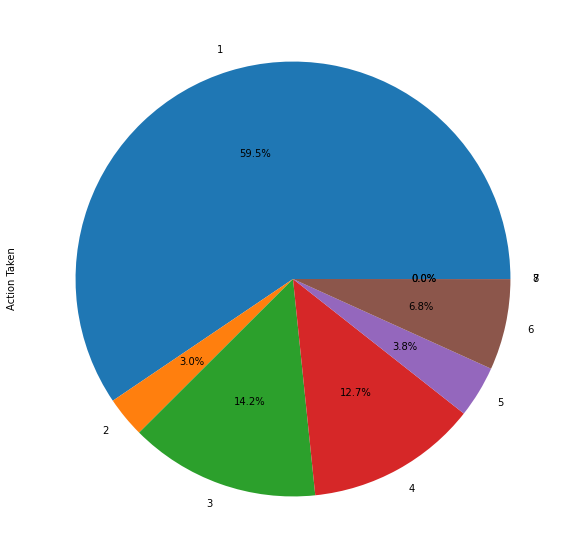

In [13]:
dataset_0['loan_type'].groupby(dataset_0['action_taken']).count().plot(kind="pie", ylabel='Action Taken',figsize=(10,10), autopct='%1.1f%%');

We need to have first three numbers for prediction model and drop other numbers. 

Combined 1 and 2 values in 1 that indicates approval.

Change 3 to 0 that indicates rejection.

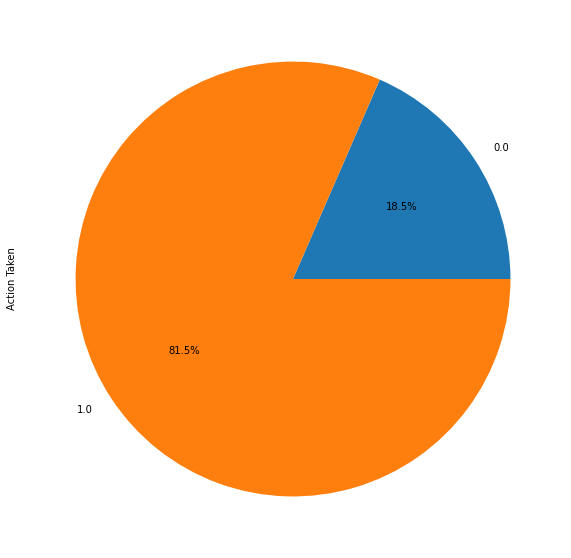

In [14]:
replace_dict = {
    'action_taken': [4,5,6,7,8]
}
dataset_0.replace(replace_dict, np.nan, inplace = True)
dataset_0['action_taken'].replace({2:1, 3:0}, inplace = True)

dataset_0['loan_type'].groupby(dataset_0['action_taken']).count().plot(kind="pie", ylabel='Action Taken',figsize=(10,10), autopct='%1.1f%%');

Removing all NaN values from datasaet.

In [15]:
dataset_0.dropna(axis=0, inplace=True)
dataset_0.count()

agency_code                       6944633
loan_type                         6944633
property_type                     6944633
owner_occupancy                   6944633
loan_amount_000s                  6944633
action_taken                      6944633
msamd                             6944633
state_code                        6944633
county_code                       6944633
census_tract_number               6944633
applicant_ethnicity               6944633
applicant_race_1                  6944633
applicant_sex                     6944633
applicant_income_000s             6944633
lien_status                       6944633
population                        6944633
minority_population               6944633
hud_median_family_income          6944633
tract_to_msamd_income             6944633
number_of_owner_occupied_units    6944633
number_of_1_to_4_family_units     6944633
dtype: int64

In [16]:
dataset_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6944633 entries, 1 to 14285495
Data columns (total 21 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   agency_code                     int64  
 1   loan_type                       int64  
 2   property_type                   int64  
 3   owner_occupancy                 float64
 4   loan_amount_000s                float64
 5   action_taken                    float64
 6   msamd                           float64
 7   state_code                      float64
 8   county_code                     float64
 9   census_tract_number             float64
 10  applicant_ethnicity             float64
 11  applicant_race_1                float64
 12  applicant_sex                   float64
 13  applicant_income_000s           float64
 14  lien_status                     int64  
 15  population                      float64
 16  minority_population             float64
 17  hud_median_family_income  

## Imbalanced data
The below graph indicates that the dataset is imblanced with more approval than rejection. It is very important that the imbalance ration tkaes into account in modeling. 


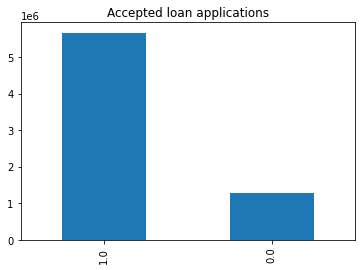

1.0    0.815335
0.0    0.184665
Name: action_taken, dtype: float64

In [17]:
dataset_0["action_taken"].value_counts().plot(kind='bar')
plt.title('Accepted loan applications')
plt.show()
dataset_0["action_taken"].value_counts(normalize = 'index')



The approval class consists 81.5% where rejection filles 18.5% of dataset.

## Plot of numerical features

In [18]:
numerical_cols = ["loan_amount_000s", "applicant_income_000s", "population", "minority_population", 
                  "census_tract_number", "hud_median_family_income", "tract_to_msamd_income",
                  "number_of_owner_occupied_units", "number_of_1_to_4_family_units"]

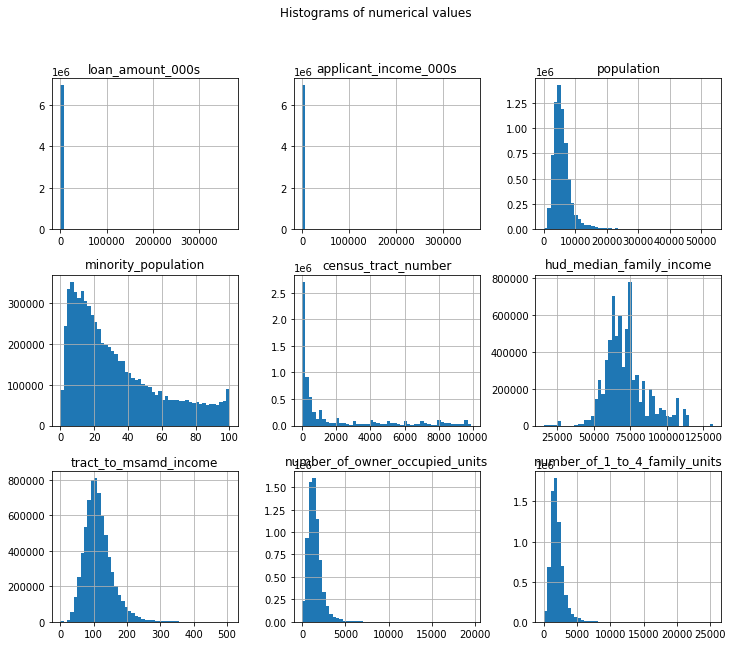

Skewness of numerical columns:


loan_amount_000s                  403.229489
applicant_income_000s             475.347291
population                          3.661120
minority_population                 0.933534
census_tract_number                 1.658787
hud_median_family_income            0.741417
tract_to_msamd_income               1.183449
number_of_owner_occupied_units      3.966787
number_of_1_to_4_family_units       3.963969
dtype: float64

In [19]:
dataset_0[numerical_cols].hist(figsize=(12,10), bins=50)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns:")
dataset_0[numerical_cols].skew()

As we can see on the histograms, as well as the list of skewness values, a few of the numerical features, especially *loan_amount* and *applicant_income* are highly skewed. 


## The KDE plots of the numerical features

The KDE plot can help to understand visually which features provide more information about the separation of two classes of approval and rejection. 

As we can see *loan_amount*, *applicant_income*, *minority_population* and *hud_median_family_income* are the most important numerical features for the binary classification.

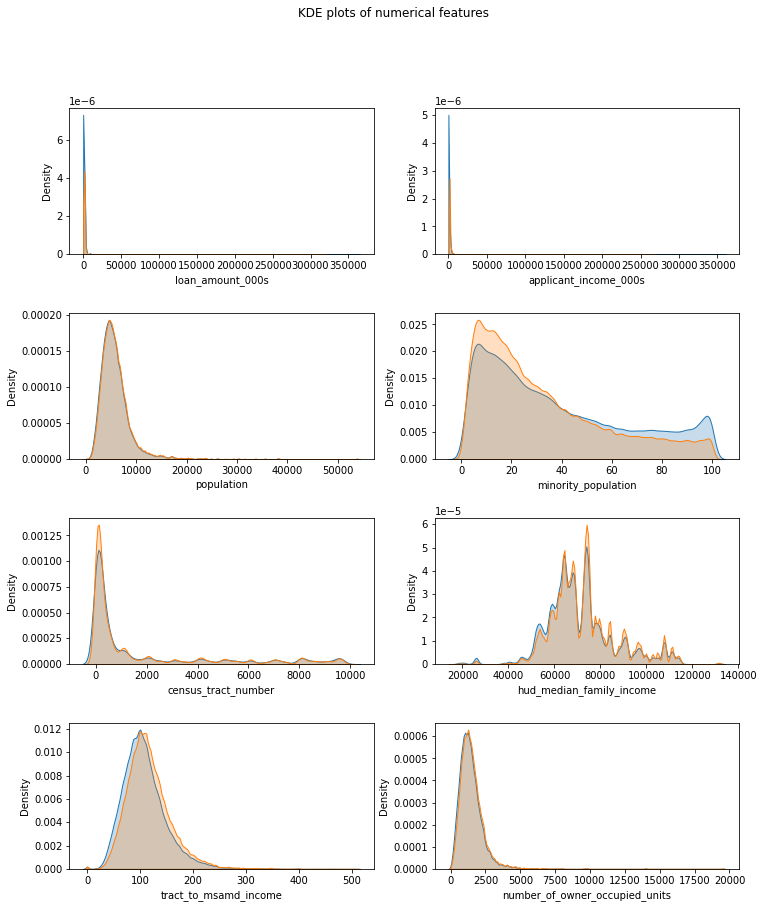

In [20]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (12,14))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
fig.suptitle("KDE plots of numerical features")

for ax, col in zip(axes.flatten(), numerical_cols) :
    sns.kdeplot(dataset_0[dataset_0['action_taken'] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(dataset_0[dataset_0['action_taken'] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)


## Ploting categorical features to visually examine class separation

As we can see, some of the categorical features provide information about class separation. 

In [21]:
cat_cols_few = ["loan_type", "property_type", "owner_occupancy", "agency_code", 
                "lien_status", "applicant_ethnicity", "applicant_race_1", "applicant_sex"] 

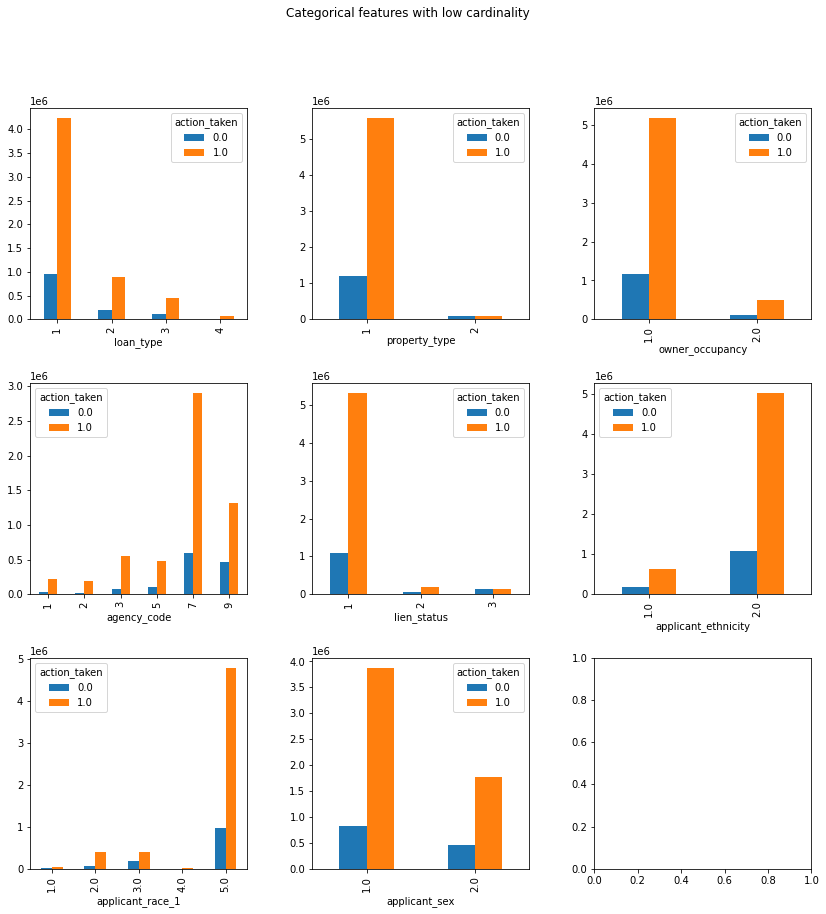

In [22]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (14,14))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features with low cardinality")

for ax, col in zip(axes.flatten(), cat_cols_few) :
    pd.crosstab(dataset_0[col], dataset_0['action_taken']).plot(kind="bar", ax = ax)
    ax.set_xlabel(col)

Some other categorical features have more clasess that make them inappropriate for bar plot.

We can see that *state_code* provide information about the separation of the target classes.

In [23]:
cat_cols_many = ["msamd", "state_code", "county_code"]

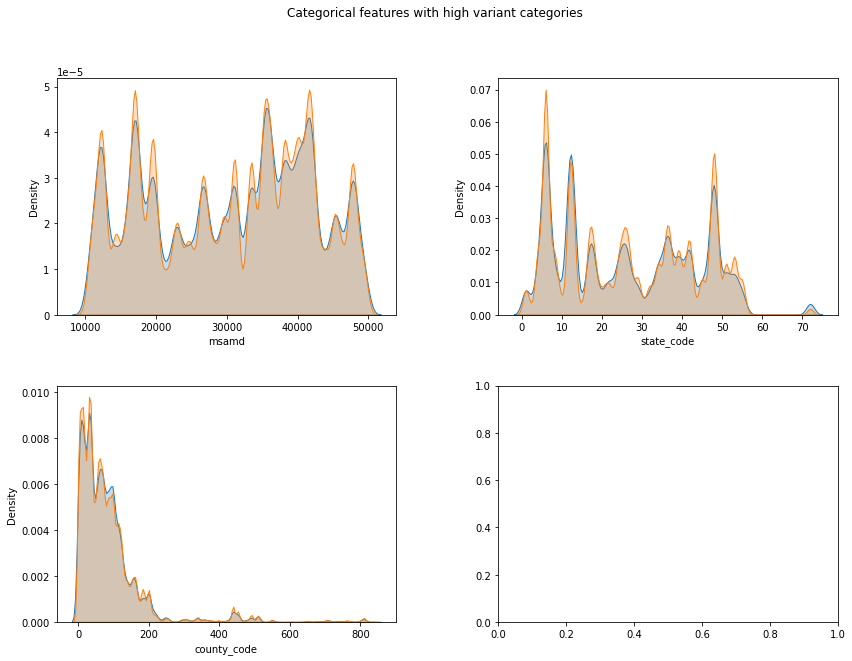

In [24]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (14,10))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features with high variant categories")

for ax, col in zip(axes.flatten(), cat_cols_many) :
    sns.kdeplot(dataset_0[dataset_0["action_taken"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(dataset_0[dataset_0["action_taken"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)


In [25]:
# save whole cleaned dataset
dataset_0.to_csv('clean_dataset.csv',sep=',', index=False)


# save random sample of 1 milion rows of cleaned data
df = dataset_0.sample(1000000)
df.to_csv('sampled_dataset.csv',sep=',', index=False)

I decided to create the new feature of 'tract_family_income'. This is the product of tract_to_msamd_income and hud_median_family_income. The feature provides useful information about class separation.

In [26]:
dataset_0["tract_family_income"] = (dataset_0["tract_to_msamd_income"] /100) * (dataset_0["hud_median_family_income"])


## Correlation in dataset

The correlation heatmap helps us visually identify any features that are highly correlated. 

Including those in the binary classifier is redundant, because the information they provide is highly overlapping, so they will be discarded from the final dataset. We can see that the new features we created earlier, are highly correlated with those that comprise them. This is fairly self-evident and reasonable, so I decided to drop the original features.

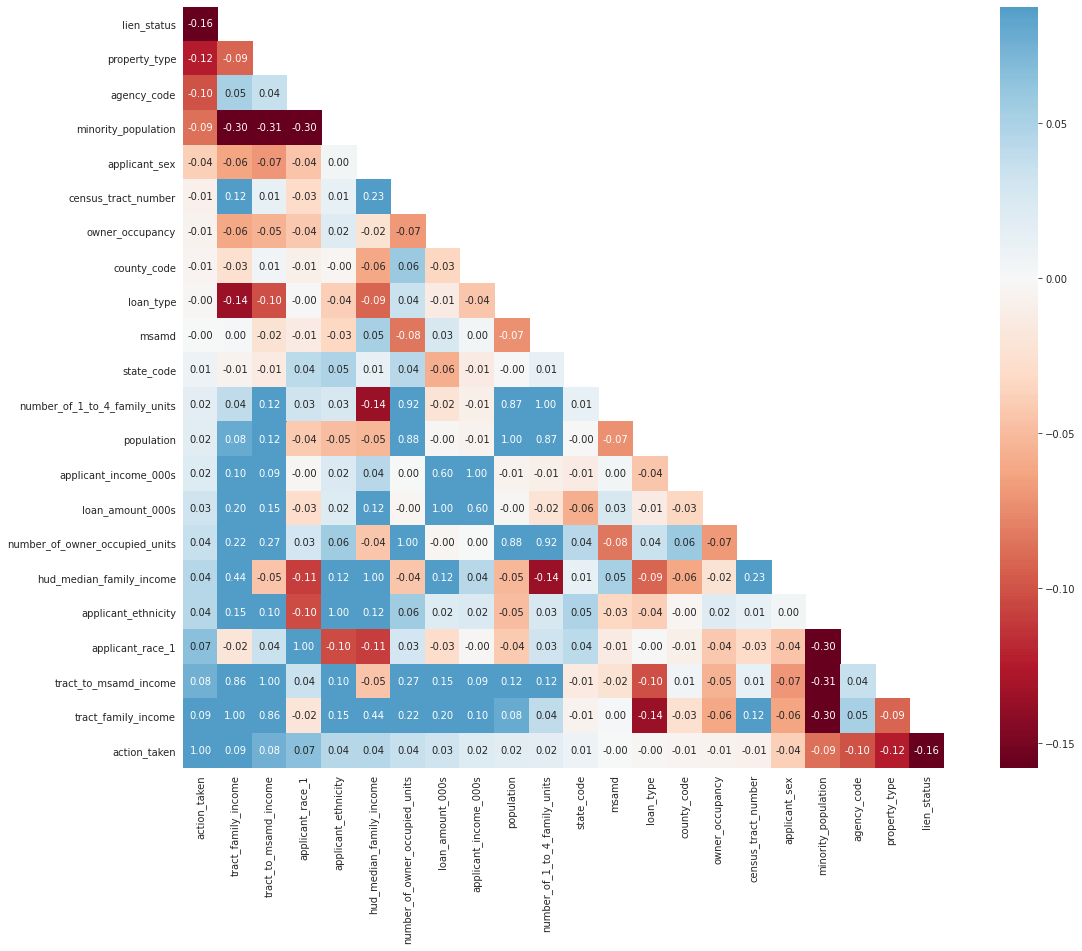

In [27]:
corr = dataset_0.corr().sort_values('action_taken', axis=1, ascending=False)
corr = corr.sort_values('action_taken', axis=0, ascending=True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True


with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 14))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.action_taken.min(), 
                     vmax=corr.drop(['action_taken'], axis=0).action_taken.max(), 
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 10})

